Rough outline on how to proceed with the poster, mostly my thinking out loud and collating relevant info on each step

# Importing the data 

Link to the Pascal challenge: \
http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html


As per Sayantan's pdf, we are only going to be doing this part of the challenge:\
Classification: For each of the twenty classes, predicting presence/absence of an example of that class in the test image.

In other words, no bounding boxes for individual features. We could optionally do that later but maybe now we can dispense with it, our task is to idenfity object classes and classify each image as containing a given class (out of 20).

# Vectorising the data

Reference features provided in the task document are as follows:

1. MPEG-7 Color Layout Descriptor \
 https://en.wikipedia.org/wiki/Color_layout_descriptor
2. Visual Bag-of-Words \
https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision
3. Speeded up robust features (SURF) \
 https://en.wikipedia.org/wiki/Speeded_up_robust_features

Again we could experiment with using different ones. We have to make sure we do feature extraction on a portion of the data, rather than the whole data, for CV, as Sayantan said this would be cheating 


# Feature selection

This is super important, one of the tasks being "Extract meaningful hand-crafted features \[...] using appropriate libraries or implement them from scratch. Reference to some hand-crafted features are provided. Identify and extract at least one extra feature of your choice other than the three features mentioned in the task. Why did you select this these feature(s) out of other options?
"

In [1]:
# You can locally install the open CV for the SURF alg
# !pip3 install opencv-python 

In [7]:
import cv2 as cv
img = cv.imread("./Data_train/JPEGImages/000005.jpg")

# cv.imshow("new window", mat=img)
# k = cv.waitKey(0) # Wait for a keystroke in the window

## Visual Bag of Words

BoVW is a method used for building image emeddings.

1. Extract visual features -> SIFT
    - consist of keypoints: points that do not change if image is rotated, expanded or scaled
    - And descriptors: vector representations of an image patch found at a given keypoint
2. Create codebook with all existing visual words -> k-means
3. Build sparse frequency vectors with these visual words

In [25]:
from scipy.cluster.vq import kmeans, vq
import numpy as np

# hyperparam iterations = 1?
# param data: list of images on which to apply bovw
# param n_words: how large should the codebook be?
def bovw(data, n_words):
    # extractor SIFT to get the visual features
    extractor = cv.SIFT_create()

    # lists to store all keypoints and descriptors
    keypoints = []
    descriptors = []

    for img in data:
        img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
        keypoints.append(img_keypoints)
        descriptors.append(img_descriptors)

    print("keypoints and descriptors extracted")

    all_descriptors = []
    # convert all discriptors into a single array (some images may have more than others)
    for img_descriptors in descriptors:
        # extract specific descriptors within the image
        for descriptor in img_descriptors:
            all_descriptors.append(descriptor)
    
    # convert to single numpy array (contains all feature vectors)
    all_descriptors = np.stack(all_descriptors)

    print("All feature vectors gathered. Now: building codebook")

    # perform k-means clustering to build the codebook
    k = n_words
    iterations = 1
    codebook, variance = kmeans(all_descriptors, k_or_guess=n_words, iter=iterations)

    print("codebook finished")

    # vector quantization
    visual_words = []
    for img_descriptors in descriptors:
        # for each image map each descriptor to the nearest codebook entry
        img_visual_words, distance = vq(img_descriptors, codebook)
        visual_words.append(img_visual_words)

    print("vectors quantization done, now: creating sparse frequency vectors")
    # creating sparse frequency_vectors 
    frequency_vectors = []
    for img_visual_words in visual_words:
        # create frequency vector for each image
        img_frequency_vector = np.zeros(k)
        for word in img_visual_words:
            img_frequency_vector[word] += 1
        frequency_vectors.append(img_frequency_vector)       
    # stack together in numpy array
    frequency_vectors = np.stack(frequency_vectors)

    print("finished bovw")

    # Tf-idf
    #N = len(data)
    #df = np.sum(frequency_vectors > 0, axis=0)
    #idf = np.log(N/df)

    #tfidf = frequency_vectors *idf

    return frequency_vectors



# Algorithm selection

I'm guessing we could get away with just picking one. I suggest constrained clustering, COP-k-Means. We could even experiment with running two separate algs and compare, like got with PCK-Means and compare the performance to COP-k-Means, they're quite similar

Here is the link to the lecture slides about these algorithms.\
https://elearning.ovgu.de/pluginfile.php/937020/mod_resource/content/2/english_ATiML05_ConstrainedClustering.pdf

Constrained clustering incorporates domain knowledge into the clustering process. In our case, domain knowledge would be super wide, essentially which features should be present for which object class. Domain knowledge that we can introduce includes 
1. Number of clusters (it's 20, Pascal tells us) 
2. Minimum cluster variance (not sure)
3. Min / Max cluster size
4. Must-link constraints
5. Cannot-link constraints

COP-k-Means is a modified k-means clustering algorithm that allows for constraints. It modifies step 1 of the k-means process (initialising cluster centres) by disallowing assignment to a cluster if the must constraint is already satisfied with another cluster or if the cannot-link constraint applies. 

The paper that describes the algorithm is here:
https://web.cse.msu.edu/~cse802/notes/ConstrainedKmeans.pdf \
It's also where the slides got their low quality screenshot of algorithm steps from

# Model selection

CV and the like, gotta plot that error as a function of lambda / M for Sayantan for sure

# Generalisation error / testing

50 % of the Pascal dataset is set to be for testing

# Load and divide the data into train and test set
- We loop through all annotation xml files
- We load those files in the `getData()` function using BeautifulSoup
- Then we get all the given lables for that image
    - Each XML file contains an object tags for each object in the image within which we can find a name tag wich holds the label
    - We then search for the name tag, strip the opening and closing tag and are left with the label itself
- We do the same to extract the filename of the image and join it with the image path
- We load the image itself using skimage
    - This loads the file as an ndarray consisting of arrays holding the RGB values for each pixel
- In the end we use sklearns `train_test_split()` method to split the data accordingly

In [1]:

from bs4 import BeautifulSoup
from skimage import io
import os
import sys
from sklearn.model_selection import train_test_split

"""Classes: person, bird, cat, cow, dog, horse, sheep, aeroplane, bicycle, boat, bus, car, motorbike, train, bottle, chair, dining table, potted plant, sofa, tv/monitor"""

jpegPath = './Data_train/JPEGImages'
annotationPath = "./Data_train/Annotations"
images = []
labels = []
x_train = x_test = y_train = y_test = None

def getData(path: str) -> list[str]:
    tempLabels = []
    with open(path, 'r') as f:
        data = f.read()
        bs_data = BeautifulSoup(data, "xml")

        #GET IMAGE LABELS
        foundLables = bs_data.find_all('object') #This holds the labels for the image
        for label in foundLables:
            labelWithTags = str(label.find('name'))
            tempLabels.append(labelWithTags.removeprefix('<name>').removesuffix('</name>'))

        #GET IMAGES
        foundFilenames = bs_data.find('filename') #This holds the filename of the image
        imagePath = os.path.join(jpegPath, str(foundFilenames).removeprefix('<filename>').removesuffix('</filename>'))
        images.append(io.imread(imagePath)) #Load image from specified path (ndarray of color values)
        f.close()
    labels.append(tempLabels)          

def getTestTrainingData():
    for annoXML in os.listdir(annotationPath):
        path = os.path.join(annotationPath, annoXML)
        getData(path)
    
    global x_train, x_test, y_train, y_test
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.5)

getTestTrainingData()
print("Train test split succeded\nTrain size: "+ str(len(x_train))+"\nTest Size: "+str(len(x_test)))

Train test split succeded
Train size: 2505
Test Size: 2506


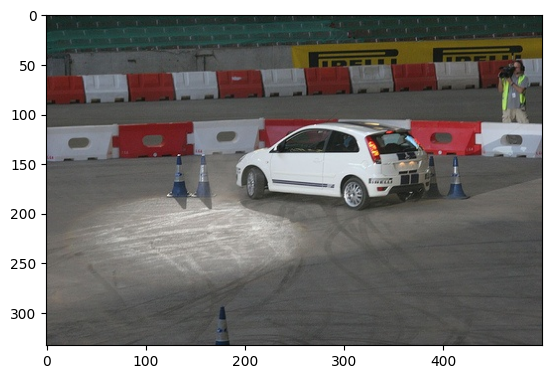

In [6]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])

In [26]:
tfidf = bovw(x_train[:500], 50)


keypoints and descriptors extracted
All feature vectors gathered. Now: building codebook
codebook finished
vectors quantization done, now: creating sparse frequency vectors
finished bovw


In [28]:
print(len(tfidf))
print(len(tfidf[0]))

500
50
